# Person Detection Using MobileNetV2 Trained on COCO 2017 Dataset

In this notebook, we will fine-tune the MobileNetV2 model using the COCO 2017 dataset to detect a person. The dataset will be converted to grayscale to match the input format of our camera (Himax We-I).

## Step 1: Install Dependencies

We first need to install the necessary libraries: TensorFlow, pycocotools (to work with the COCO dataset), and OpenCV (to handle image processing).



In [1]:
!pip install tensorflow pycocotools opencv-python numpy  requests  matplotlib ipywidgets

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Input, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os
import shutil
import zipfile
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import requests

In [3]:
# Define the COCO dataset URLs
coco_images_url = 'http://images.cocodataset.org/zips/train2017.zip'
coco_annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

# Define download paths
data_dir = './coco2017/'
images_zip_path = os.path.join(data_dir, 'train2017.zip')
annotations_zip_path = os.path.join(data_dir, 'annotations_trainval2017.zip')

# Create directory to store dataset
os.makedirs(data_dir, exist_ok=True)

# Download images
if not os.path.exists(os.path.join(data_dir, 'train2017')):
    print("Downloading COCO train images...")
    r = requests.get(coco_images_url, stream=True)
    with open(images_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip images
    with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO train images downloaded and extracted.")

# Download annotations
if not os.path.exists(os.path.join(data_dir, 'annotations')):
    print("Downloading COCO annotations...")
    r = requests.get(coco_annotations_url, stream=True)
    with open(annotations_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    
    # Unzip annotations
    with zipfile.ZipFile(annotations_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("COCO annotations downloaded and extracted.")

In [4]:
# Initialize COCO API
annotation_file = os.path.join(data_dir, 'annotations/instances_train2017.json')
coco = COCO(annotation_file)

# Get the category ID for "person"
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all images containing people (positive samples)
person_image_ids = coco.getImgIds(catIds=[person_category_id])

# Get some images without people (negative samples)
all_image_ids = coco.getImgIds()
non_person_image_ids = list(set(all_image_ids) - set(person_image_ids))

# Load and preprocess the image, convert grayscale to 3-channel by replicating
def load_and_preprocess_image(coco, img_id, data_dir, img_size=(224, 224)):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, 'train2017', img_info['file_name'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
    
    img = cv2.resize(img, img_size)  # Resize to match MobileNetV2 input size
    img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale image
    return img


# Load person images
person_images = [load_and_preprocess_image(coco, img_id, data_dir) for img_id in person_image_ids[:2000]]  
non_person_images = [load_and_preprocess_image(coco, img_id, data_dir) for img_id in non_person_image_ids[:2000]]

# Create labels (1 for person, 0 for non-person)
labels = np.array([1] * len(person_images) + [0] * len(non_person_images))

# Combine images and shuffle the dataset
images = np.array(person_images + non_person_images)
indices = np.random.permutation(len(images))
images, labels = images[indices], labels[indices]

loading annotations into memory...
Done (t=74.16s)
creating index...
index created!


In [5]:


# Define a new input layer that accepts grayscale (1-channel) images
input_layer = Input(shape=(224, 224, 1))

# Use Conv2D to change 1-channel input to 3-channel so it can work with MobileNetV2
x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Modify the first layer to accept 1-channel input and broadcast to 3 channels
input_layer = Input(shape=(224, 224, 1))  # Grayscale input
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(input_layer)  # Convert grayscale to RGB

# Connect the base model
base_model_output = base_model(x)

# Add custom layers on top of the base model
x = Dropout(0.5)(x)  # Added Dropout for regularization
x = Dense(64, activation='relu')(x)  # Added Dense layer for more complexity

x = GlobalAveragePooling2D()(base_model_output)
x = Dense(1, activation='sigmoid')(x)  # For binary classification (person vs non-person)

# Create the final model
model = Model(inputs=input_layer, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
def preprocess_input(images):
    # If images are in (batch_size, height, width) format, add channel dimension
    if images.ndim == 3:
        images = np.expand_dims(images, axis=-1)  # Add grayscale channel
    elif images.ndim == 4 and images.shape[-1] != 1:  # Handle other cases
        raise ValueError("Images must be in grayscale format with shape (batch_size, 224, 224, 1).")
    return images  # Return images with shape (batch_size, height, width, channels)

# ImageDataGenerator for augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


# Assuming 'images' is a 4D array with shape (batch_size, 224, 224, 1)
train_generator = datagen.flow(
    images,  # Raw images, no need to preprocess explicitly here
    labels,
    batch_size=32,
    subset='training'
)

val_generator = datagen.flow(
    images,
    labels,
    batch_size=32,
    subset='validation'
)

# Learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1
)

# Fine-tuning MobileNetV2
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False


Epoch 1/15


c:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.7310 - loss: 0.5622 - val_accuracy: 0.5587 - val_loss: 4.3157
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8128 - loss: 0.4142 - val_accuracy: 0.5200 - val_loss: 5.8170
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8241 - loss: 0.3755 - val_accuracy: 0.5312 - val_loss: 6.0173
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.8561 - loss: 0.3392 - val_accuracy: 0.5625 - val_loss: 4.8102
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8593 - loss: 0.3245 - val_accuracy: 0.5150 - val_loss: 4.0326
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8696 - loss: 0.3021 - val_accuracy: 0.5475 - val_loss: 3.5605
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.8942 - loss: 0.2531 - val_accuracy: 0.6187 - val_loss: 3.1396
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8895 - loss: 0.2593 - val_accuracy: 0.740

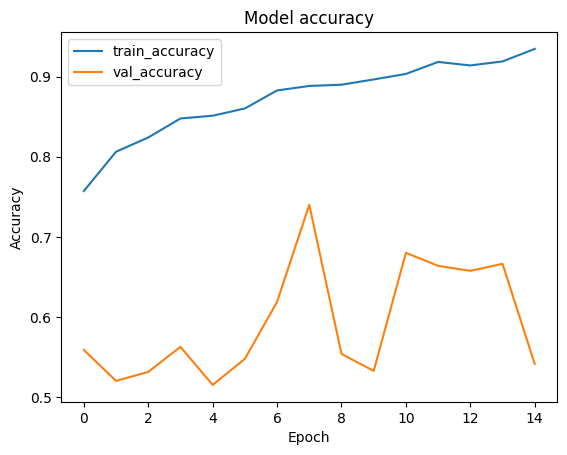

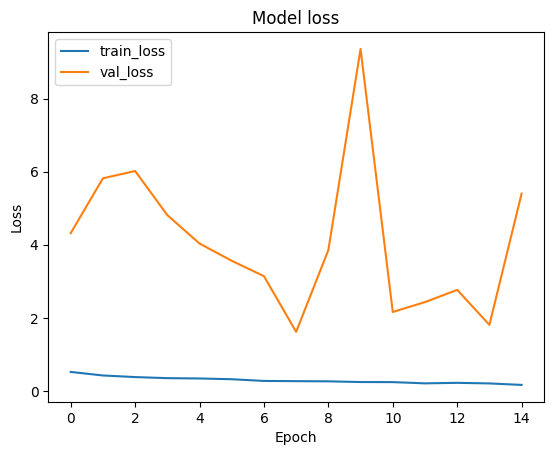

In [7]:
# Train the model
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=15
)


# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()